## Import Data


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# === Import ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [3]:
# === 1. Load & Cleaning ===
data = pd.read_csv("DukuhKupang.csv")
drop_cols = ['Datetime','Timezone','AQI CN','AQI US','HCHO (ppb)','TVOC (ppb)']
data = data.drop(columns=drop_cols).dropna().drop_duplicates()

In [4]:
print(data.isna().sum())
print(data.isnull().sum())
print(data.duplicated().sum())

PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
0


In [5]:
# Outlier removal (1x saja, bukan looping panjang)
Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
IQR = Q3 - Q1
mask = ~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis=1)
data = data[mask]
data

,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
25,16.0,35,427,37.6,99.6,49
26,12.0,30,426,37.6,99.6,48
27,16.0,35,422,37.5,99.4,50
28,12.0,18,421,37.3,99.1,49
29,11.0,13,424,37.1,98.8,50
...,...,...,...,...,...,...
40038,38.0,72,413,35.1,95.1,56
40039,41.0,91,412,35.1,95.1,57
40040,39.0,84,413,35.1,95.2,57
40041,36.0,66,419,35.4,95.6,57


In [6]:
print("Final shape setelah cleaning:", data.shape)

Final shape setelah cleaning: (33938, 6)


In [7]:
## cek data Oulier

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = data[(data < lower_bound) | (data > upper_bound)].dropna(how='all').index
print(f"Number of potential outliers detected: {len(outlier_indices)}")

Number of potential outliers detected: 2066


In [8]:
## Hapus data Oulier
data_cleaned_looped = data.copy() # Create a copy to avoid modifying the original data

while True:
    Q1 = data_cleaned_looped.quantile(0.25)
    Q3 = data_cleaned_looped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = data_cleaned_looped[(data_cleaned_looped < lower_bound) | (data_cleaned_looped > upper_bound)].dropna(how='all').index

    if len(outlier_indices) == 0:
        print("No more outliers detected.")
        break
    else:
        print(f"Removing {len(outlier_indices)} potential outliers.")
        data_cleaned_looped = data_cleaned_looped.drop(outlier_indices)

print(f"Number of rows after removing outliers iteratively: {len(data_cleaned_looped)}")
display(data_cleaned_looped.head())

Removing 2066 potential outliers.
Removing 987 potential outliers.
Removing 431 potential outliers.
Removing 229 potential outliers.
Removing 135 potential outliers.
Removing 170 potential outliers.
Removing 355 potential outliers.
No more outliers detected.
Number of rows after removing outliers iteratively: 29565


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
25,16.0,35,427,37.6,99.6,49
26,12.0,30,426,37.6,99.6,48
27,16.0,35,422,37.5,99.4,50
28,12.0,18,421,37.3,99.1,49
29,11.0,13,424,37.1,98.8,50


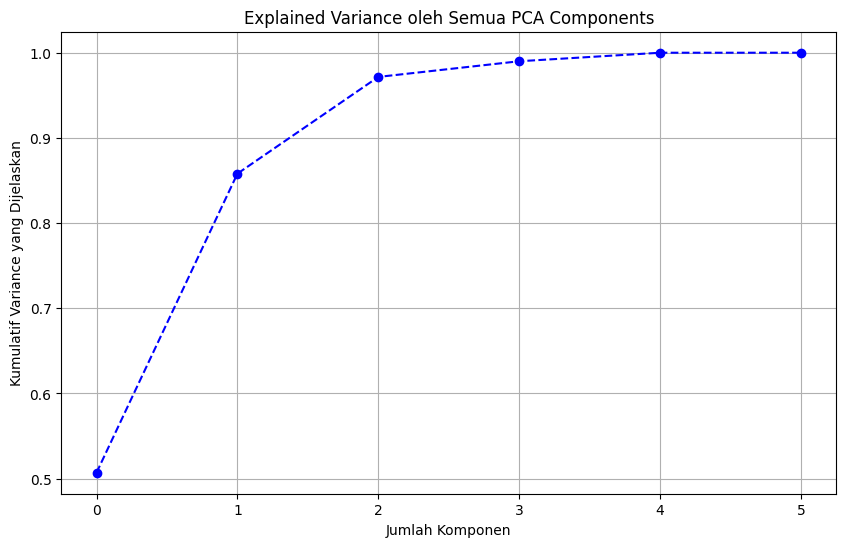

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data_cleaned_looped , test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === PCA untuk semua komponen ===
pca_full = PCA()  # tanpa n_components, supaya semua komponen dihitung
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Kumulatif Variance yang Dijelaskan')
plt.title('Explained Variance oleh Semua PCA Components')
plt.grid(True)
plt.show()


In [10]:
# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 3. PCA ===
pca = PCA(n_components=2)   # 3 biar bisa 2D/3D plot
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


In [11]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.53641946 0.34457442]
Total explained variance: 0.8809938806165778


In [12]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# Range jumlah cluster yang diuji
cluster_range = range(2, 11)  # bisa diatur sesuai kebutuhan

silhouette_scores = {}

# Loop dengan tqdm
for n_clusters in tqdm(cluster_range, desc="Evaluating clusters", unit="cluster"):
    ahc = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = ahc.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    print(f"n_cluster = {n_clusters} Silhouette Score = {score}")
    silhouette_scores[n_clusters] = score

# Cari jumlah cluster optimal
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)

print("\n--- Analisis Silhouette Score ---")
for n, score in silhouette_scores.items():
    print(f"Jumlah cluster {n}: Silhouette Score = {score:.4f}")

print(f"\nJumlah cluster optimal berdasarkan Silhouette Score: {optimal_clusters}")


Evaluating clusters:  11%|█         | 1/9 [00:17<02:19, 17.48s/cluster]

n_cluster = 2 Silhouette Score = 0.41706687371920975


Evaluating clusters:  22%|██▏       | 2/9 [00:32<01:54, 16.29s/cluster]

n_cluster = 3 Silhouette Score = 0.43966358602804023


Evaluating clusters:  33%|███▎      | 3/9 [00:45<01:28, 14.77s/cluster]

n_cluster = 4 Silhouette Score = 0.3257969339458037


Evaluating clusters:  44%|████▍     | 4/9 [01:00<01:12, 14.54s/cluster]

n_cluster = 5 Silhouette Score = 0.3194845927672646


Evaluating clusters:  56%|█████▌    | 5/9 [01:14<00:57, 14.35s/cluster]

n_cluster = 6 Silhouette Score = 0.3142625907730472


Evaluating clusters:  67%|██████▋   | 6/9 [01:26<00:41, 13.80s/cluster]

n_cluster = 7 Silhouette Score = 0.2988152087998702


Evaluating clusters:  78%|███████▊  | 7/9 [01:39<00:26, 13.44s/cluster]

n_cluster = 8 Silhouette Score = 0.3029113994548017


Evaluating clusters:  89%|████████▉ | 8/9 [01:54<00:13, 13.92s/cluster]

n_cluster = 9 Silhouette Score = 0.29757840694666216


Evaluating clusters: 100%|██████████| 9/9 [02:09<00:00, 14.41s/cluster]

n_cluster = 10 Silhouette Score = 0.29062240244605914

--- Analisis Silhouette Score ---
Jumlah cluster 2: Silhouette Score = 0.4171
Jumlah cluster 3: Silhouette Score = 0.4397
Jumlah cluster 4: Silhouette Score = 0.3258
Jumlah cluster 5: Silhouette Score = 0.3195
Jumlah cluster 6: Silhouette Score = 0.3143
Jumlah cluster 7: Silhouette Score = 0.2988
Jumlah cluster 8: Silhouette Score = 0.3029
Jumlah cluster 9: Silhouette Score = 0.2976
Jumlah cluster 10: Silhouette Score = 0.2906

Jumlah cluster optimal berdasarkan Silhouette Score: 3


Silhouette Score: 0.4397
Davies-Bouldin Index: 0.7953


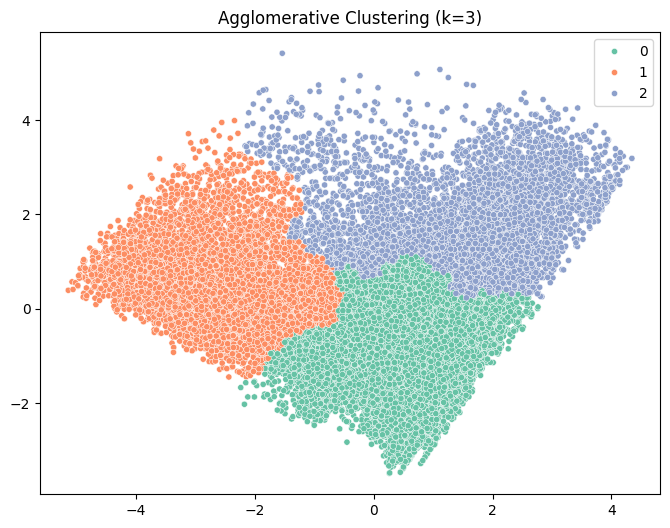

             PM2.5 (ug/m3)  PM10 (ug/m3)   CO2 (ppm)  Temperature (Celsius)  \
Cluster_AHC                                                                   
0                26.415707     47.717504  422.152864              26.749979   
1                22.826323     46.020227  420.485870              33.255889   
2                59.539825    113.653853  443.612376              27.786444   

             Temperature (Fahrenheit)  Humidity (%)  
Cluster_AHC                                          
0                           80.149853     86.125842  
1                           91.861942     63.538230  
2                           82.016962     83.300287  


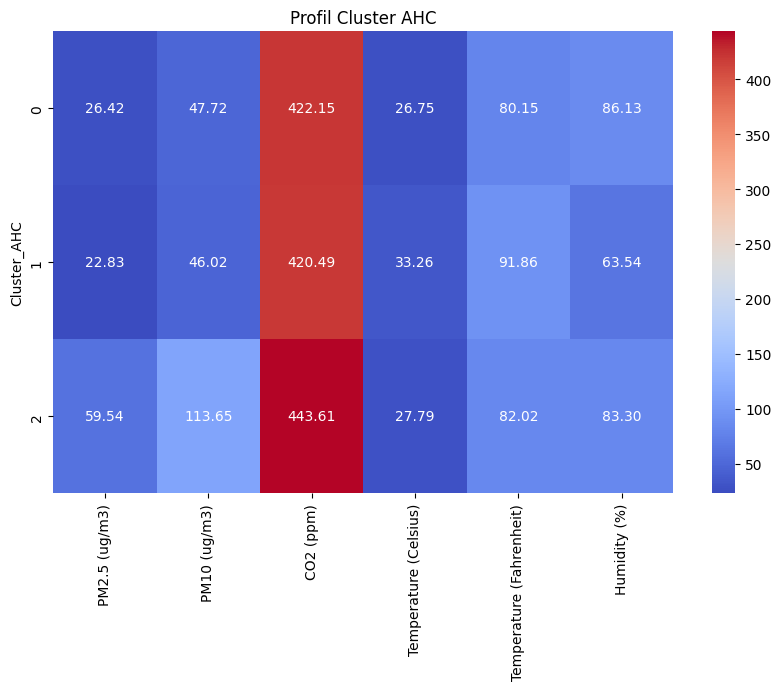

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit dengan jumlah cluster optimal
ahc_optimal = AgglomerativeClustering(n_clusters=optimal_clusters, linkage="ward")
ahc_labels = ahc_optimal.fit_predict(X_train_pca)

# Evaluasi
sil_score = silhouette_score(X_train_pca, ahc_labels)
dbi_score = davies_bouldin_score(X_train_pca, ahc_labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

# %%
# Visualisasi PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=ahc_labels, palette="Set2", s=20)
plt.title(f"Agglomerative Clustering (k={optimal_clusters})")
plt.show()

# %%
# Profil cluster
X_train["Cluster_AHC"] = ahc_labels
cluster_profile = X_train.groupby("Cluster_AHC").mean()
print(cluster_profile)

plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Profil Cluster AHC")
plt.show()

In [15]:
# --- Fungsi AQI ---
import numpy as np

# Tabel breakpoints (Bmin, Bmax, Imin, Imax)
breakpoints = {
    "PM2.5": [(0, 30, 0, 50),
              (31, 60, 51, 100),
              (61, 90, 101, 200),
              (91, 120, 201, 300),
              (121, 250, 301, 400)],
    
    "PM10": [(0, 50, 0, 50),
             (51, 100, 51, 100),
             (101, 250, 101, 200),
             (251, 350, 201, 300),
             (351, 430, 301, 400)],
    
    # Sementara pakai kategori CO (mg/m3) diadaptasi ke ppm (contoh kasar)
}

def calculate_sub_index(pollutant, concentration):
    for (Bmin, Bmax, Imin, Imax) in breakpoints[pollutant]:
        if Bmin <= concentration <= Bmax:
            return ((Imax - Imin) / (Bmax - Bmin)) * (concentration - Bmin) + Imin
    return np.nan
def calculate_aqi_linear(row):
    sub_pm25 = calculate_sub_index("PM2.5", row["PM2.5 (ug/m3)"])
    sub_pm10 = calculate_sub_index("PM10", row["PM10 (ug/m3)"])
    
    return max(sub_pm25, sub_pm10)

def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"
    
X_train["AQI_Value"] = X_train.apply(calculate_aqi_linear, axis=1)
X_train["AQI_Category"] = X_train["AQI_Value"].apply(categorize_aqi)



AQI_Category  Good  Moderate  Poor  Satisfactory  Severe
Cluster_AHC                                             
0             7658       155     0          6432       3
1             4280       120     0          2569       2
2                3      3657    62          2031     178


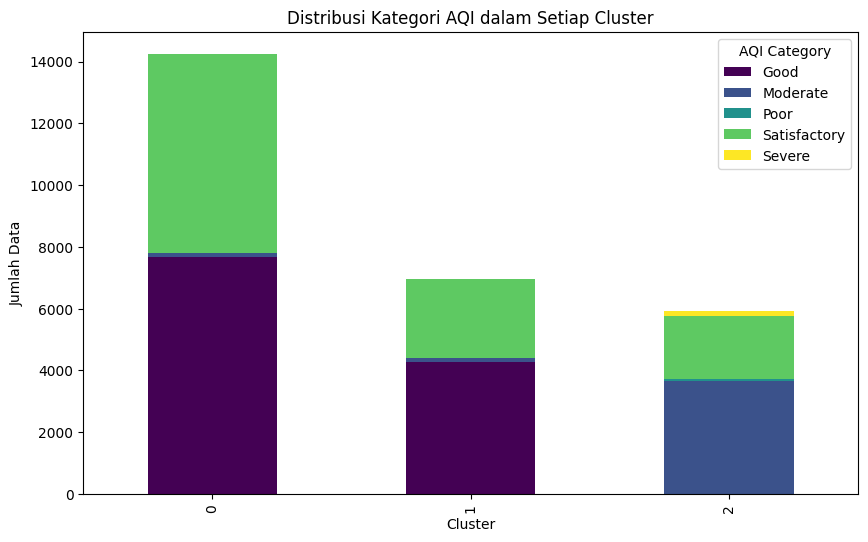

In [16]:
# Crosstab cluster vs AQI Category
cluster_summary = pd.crosstab(X_train["Cluster_AHC"], X_train["AQI_Category"])
print(cluster_summary)

# Plot stacked bar
cluster_summary.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()
